In [ ]:
!cd drive/MyDrive/;mv dadekavi.csv transfusion.data.csv;ls

In [1]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/

/content/drive/MyDrive


In [180]:
!pip install -q --upgrade scikit-learn
!pip install -q scikit-optimize==0.9.0
!pip install -q scikit-learn bayesian-optimization

In [139]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import distance
from mpl_toolkits.mplot3d import Axes3D
from skopt import gp_minimize
from skopt.space import Integer
from bayes_opt import BayesianOptimization

In [6]:
try:
    df = pd.read_csv('transfusion.data.csv')
    print('successfully read dataset') # Print the first few rows to verify successful reading
except pd.errors.ParserError as e:
    print(f"Error reading CSV: {e}")
    # Consider inspecting line 25 of the file for anomalies


successfully read dataset


In [7]:
df.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [8]:
df.shape

(748, 5)

In [9]:
df.describe()


,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Recency (months)                            748 non-null    int64
 1   Frequency (times)                           748 non-null    int64
 2   Monetary (c.c. blood)                       748 non-null    int64
 3   Time (months)                               748 non-null    int64
 4   whether he/she donated blood in March 2007  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


# There is a strong linear relationship between the volume of blood donated and the number of times blood is donated, which is completely logical.

In [11]:
correlation = df.corr()
correlation['whether he/she donated blood in March 2007'].sort_values(ascending=False)

whether he/she donated blood in March 2007    1.000000
Monetary (c.c. blood)                         0.218633
Frequency (times)                             0.218633
Time (months)                                -0.035854
Recency (months)                             -0.279869
Name: whether he/she donated blood in March 2007, dtype: float64

Correlation between Frequency and Monetary: 0.9999999999999992


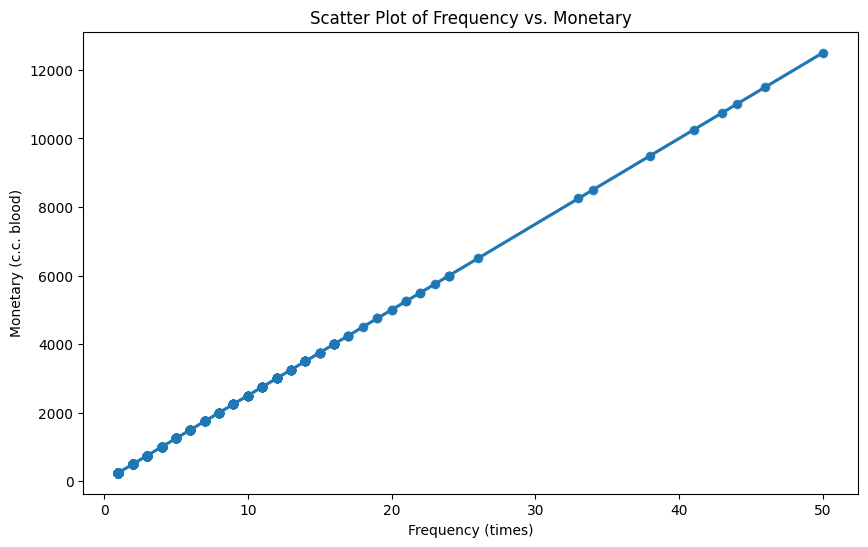

In [12]:
correlation = df['Frequency (times)'].corr(df['Monetary (c.c. blood)'])
print(f"Correlation between Frequency and Monetary: {correlation}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency (times)', y='Monetary (c.c. blood)', data=df)
plt.title('Scatter Plot of Frequency vs. Monetary')
plt.xlabel('Frequency (times)')
plt.ylabel('Monetary (c.c. blood)')

# Fit a linear regression line
sns.regplot(x='Frequency (times)', y='Monetary (c.c. blood)', data=df)

plt.show()


Correlation between Frequency and Monetary: 0.6349402703229287


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


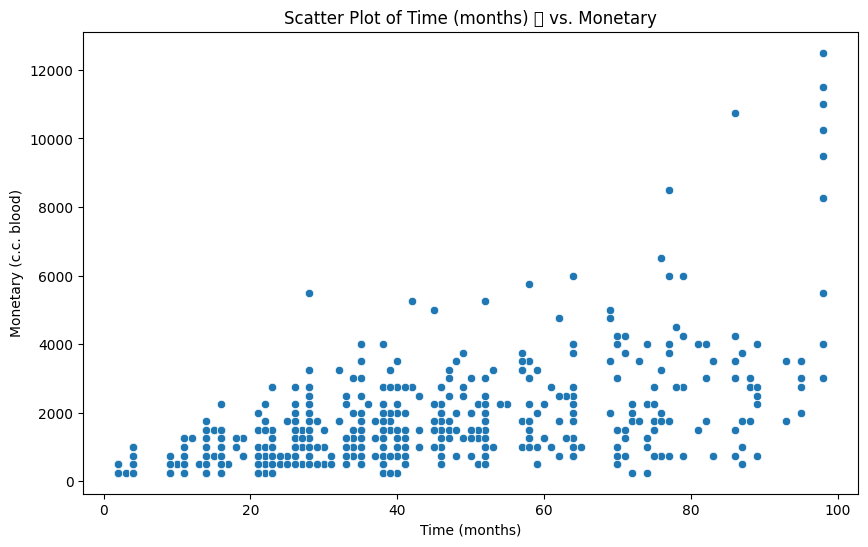

In [13]:
correlation = df['Time (months)'].corr(df['Monetary (c.c. blood)'])
print(f"Correlation between Frequency and Monetary: {correlation}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Time (months)', y='Monetary (c.c. blood)', data=df)
plt.title('Scatter Plot of Time (months) 	 vs. Monetary')
plt.xlabel('Time (months)')
plt.ylabel('Monetary (c.c. blood)')
plt.show()


Correlation between Frequency and Recency (months): 0.160618094175185


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


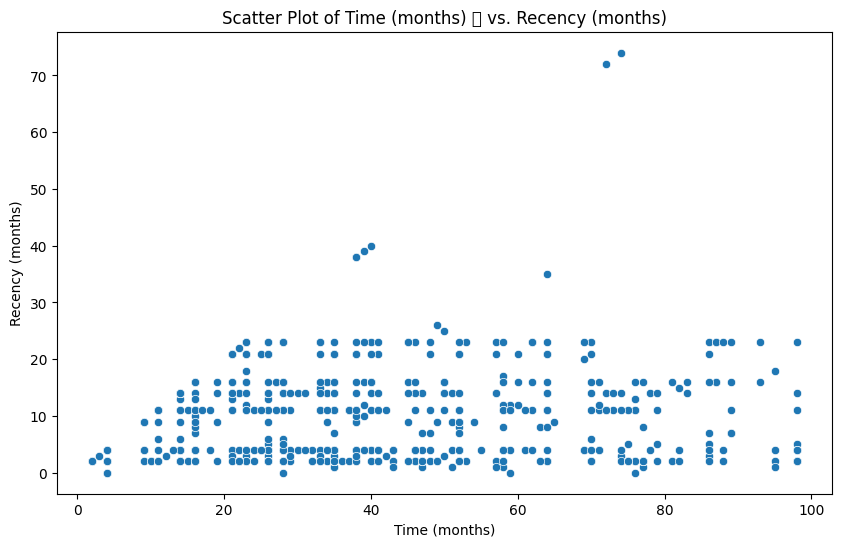

In [14]:
correlation = df['Time (months)'].corr(df['Recency (months)'])
print(f"Correlation between Frequency and Recency (months): {correlation}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Time (months)', y='Recency (months)', data=df)
plt.title('Scatter Plot of Time (months) 	 vs. Recency (months)')
plt.xlabel('Time (months)')
plt.ylabel('Recency (months)')
plt.show()

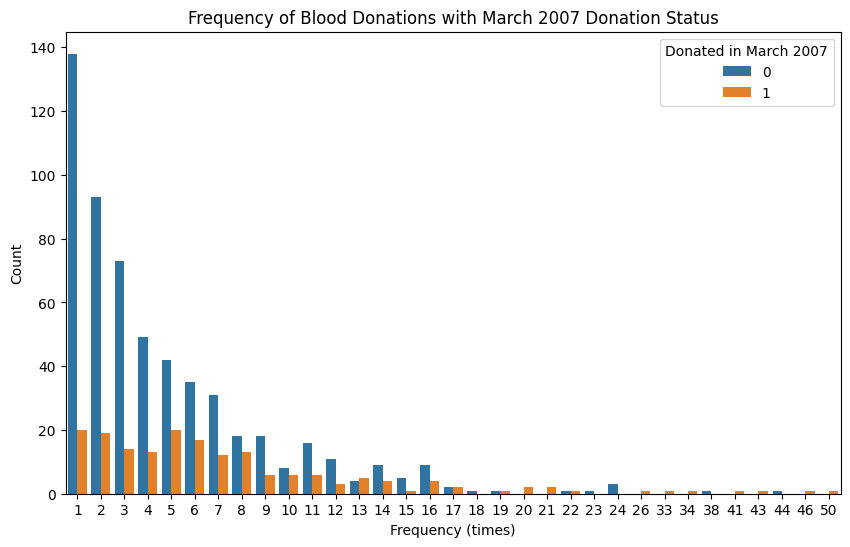

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Frequency (times)', hue='whether he/she donated blood in March 2007', data=df)
plt.title('Frequency of Blood Donations with March 2007 Donation Status')
plt.xlabel('Frequency (times)')
plt.ylabel('Count')
plt.legend(title='Donated in March 2007', loc='upper right')
plt.show()


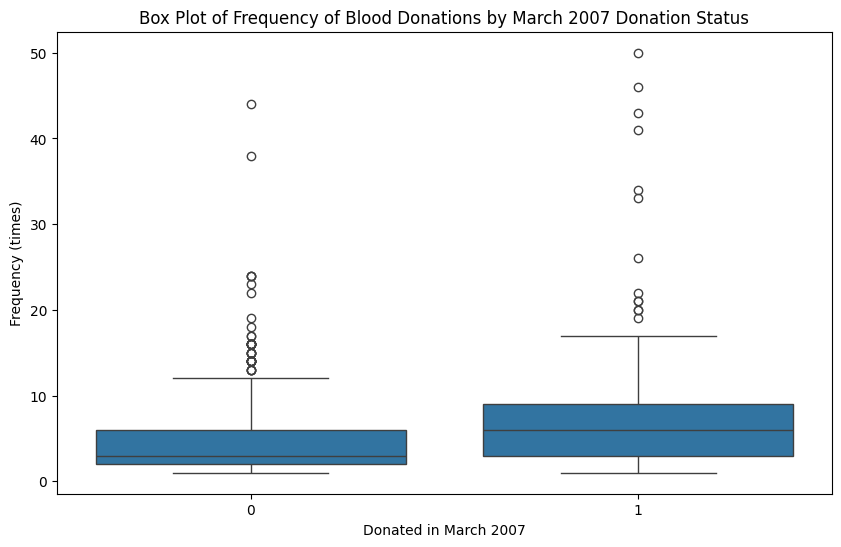

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='whether he/she donated blood in March 2007', y='Frequency (times)', data=df)
plt.title('Box Plot of Frequency of Blood Donations by March 2007 Donation Status')
plt.xlabel('Donated in March 2007')
plt.ylabel('Frequency (times)')
plt.show()


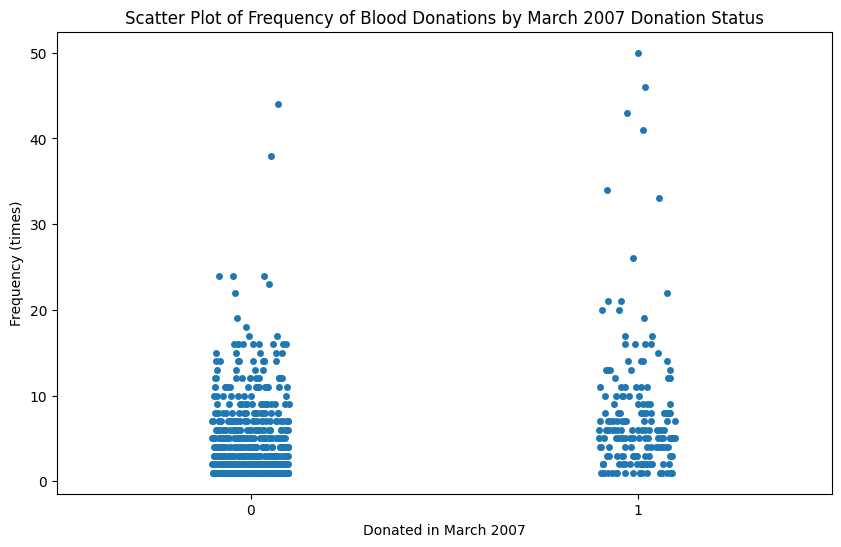

In [17]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='whether he/she donated blood in March 2007', y='Frequency (times)', data=df, jitter=True)
plt.title('Scatter Plot of Frequency of Blood Donations by March 2007 Donation Status')
plt.xlabel('Donated in March 2007')
plt.ylabel('Frequency (times)')
plt.show()

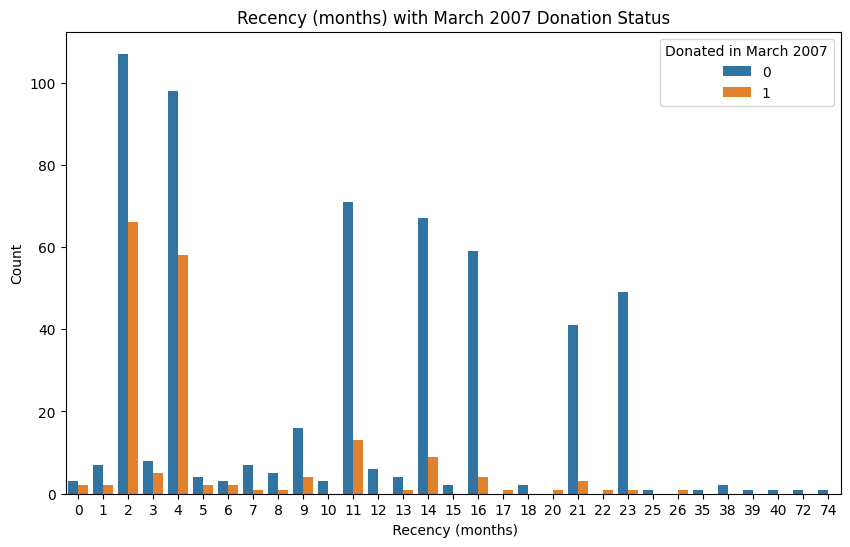

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Recency (months)', hue='whether he/she donated blood in March 2007', data=df)
plt.title('Recency (months) with March 2007 Donation Status')
plt.xlabel(' Recency (months)')
plt.ylabel('Count')
plt.legend(title='Donated in March 2007', loc='upper right')
plt.show()


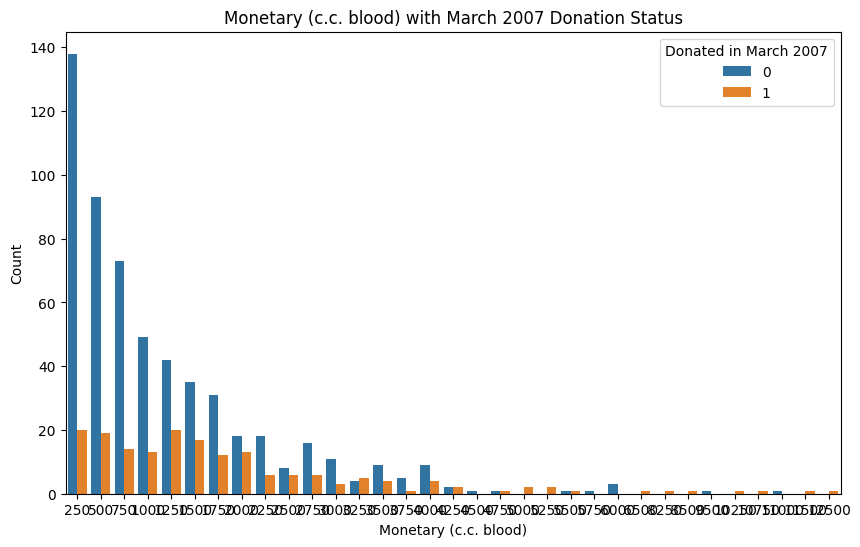

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Monetary (c.c. blood)', hue='whether he/she donated blood in March 2007', data=df)
plt.title('Monetary (c.c. blood) with March 2007 Donation Status')
plt.xlabel('Monetary (c.c. blood)')
plt.ylabel('Count')
plt.legend(title='Donated in March 2007', loc='upper right')
plt.show()


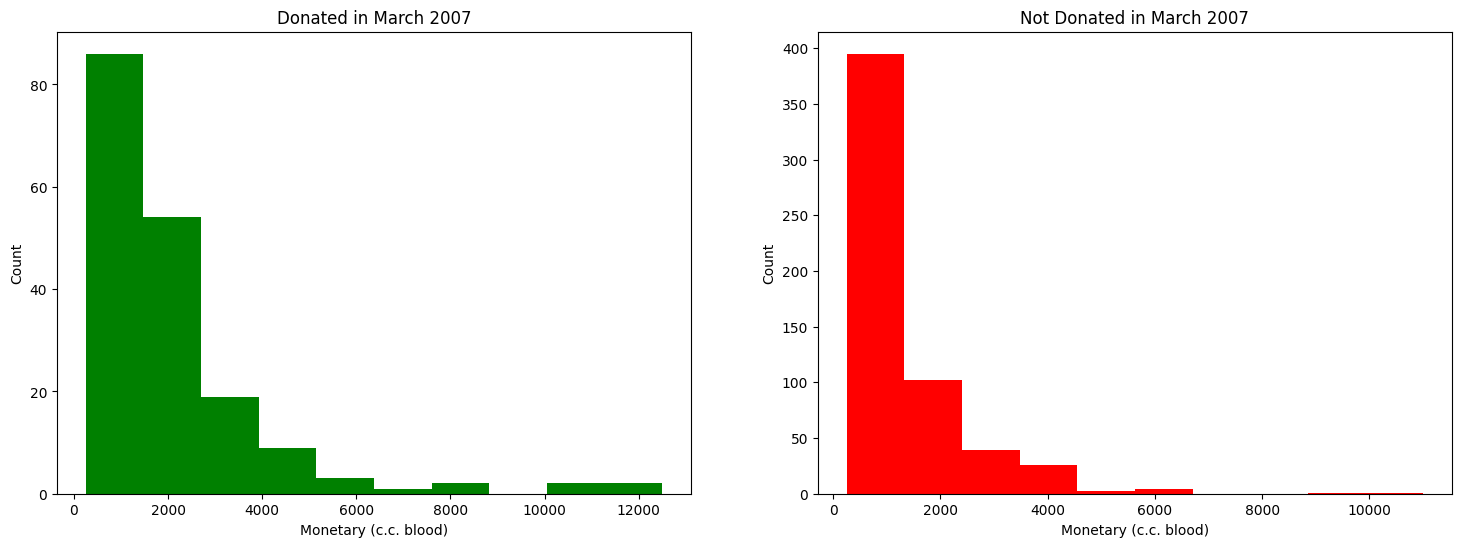

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histogram for donated in March 2007
axes[0].hist(df[df['whether he/she donated blood in March 2007'] == 1]['Monetary (c.c. blood)'], bins=10, color='green')
axes[0].set_title('Donated in March 2007')
axes[0].set_xlabel('Monetary (c.c. blood)')
axes[0].set_ylabel('Count')

# Histogram for not donated in March 2007
axes[1].hist(df[df['whether he/she donated blood in March 2007'] == 0]['Monetary (c.c. blood)'], bins=10, color='red')
axes[1].set_title('Not Donated in March 2007')
axes[1].set_xlabel('Monetary (c.c. blood)')
axes[1].set_ylabel('Count')

plt.show()


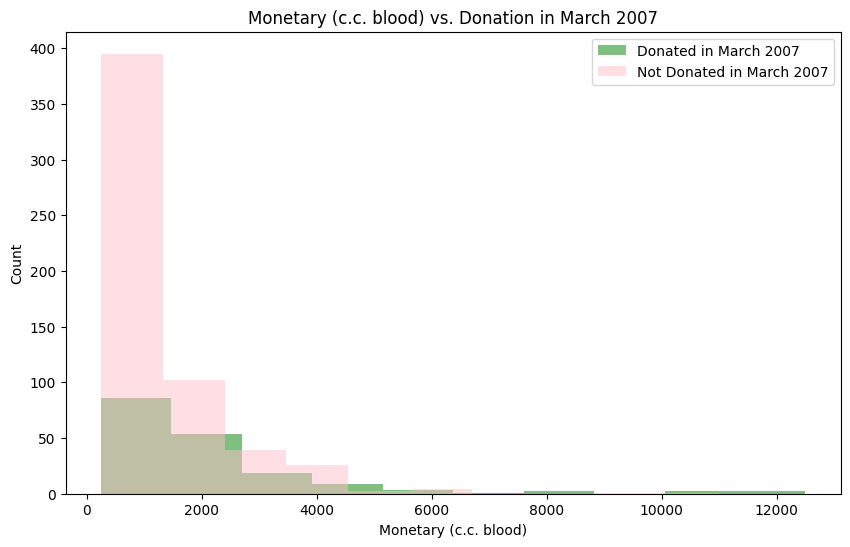

In [21]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram for donated in March 2007
ax.hist(df[df['whether he/she donated blood in March 2007'] == 1]['Monetary (c.c. blood)'], bins=10, color='green', alpha=0.5, label='Donated in March 2007')

# Plot the histogram for not donated in March 2007
ax.hist(df[df['whether he/she donated blood in March 2007'] == 0]['Monetary (c.c. blood)'], bins=10, color='pink', alpha=0.5, label='Not Donated in March 2007')

# Add title, labels and legend
ax.set_title('Monetary (c.c. blood) vs. Donation in March 2007')
ax.set_xlabel('Monetary (c.c. blood)')
ax.set_ylabel('Count')
ax.legend()

# Show the plot
plt.show()


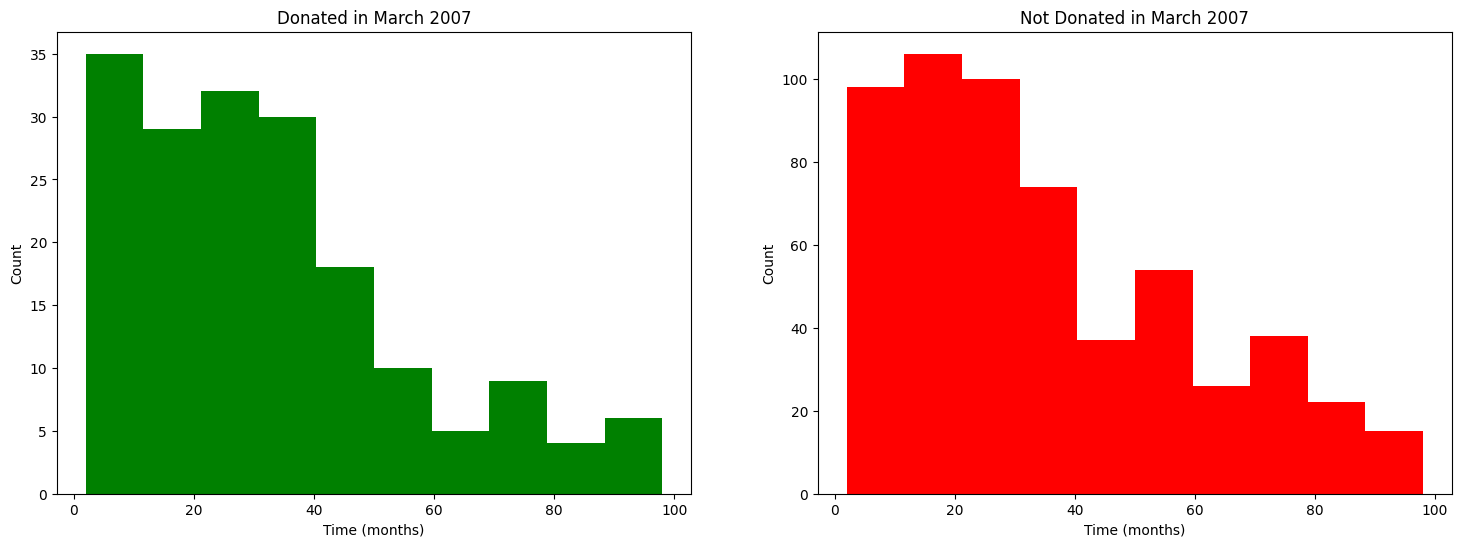

In [22]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the histogram for donated in March 2007
axes[0].hist(df[df['whether he/she donated blood in March 2007'] == 1]['Time (months)'], bins=10, color='green')
axes[0].set_title('Donated in March 2007')
axes[0].set_xlabel('Time (months)')
axes[0].set_ylabel('Count')

# Plot the histogram for not donated in March 2007
axes[1].hist(df[df['whether he/she donated blood in March 2007'] == 0]['Time (months)'], bins=10, color='red')
axes[1].set_title('Not Donated in March 2007')
axes[1].set_xlabel('Time (months)')
axes[1].set_ylabel('Count')

plt.show()


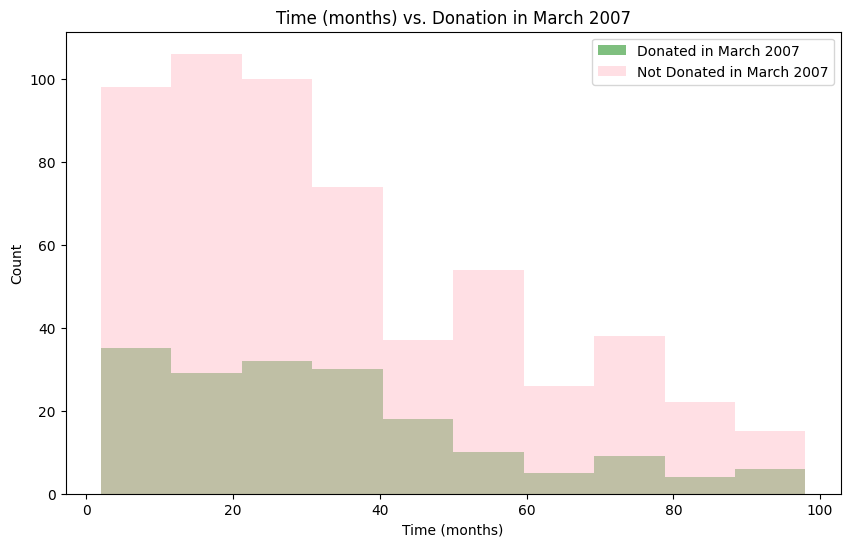

In [23]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram for donated in March 2007
ax.hist(df[df['whether he/she donated blood in March 2007'] == 1]['Time (months)'], bins=10, color='green', alpha=0.5, label='Donated in March 2007')

# Plot the histogram for not donated in March 2007
ax.hist(df[df['whether he/she donated blood in March 2007'] == 0]['Time (months)'], bins=10, color='pink', alpha=0.5, label='Not Donated in March 2007')

# Add title, labels and legend
ax.set_title('Time (months) vs. Donation in March 2007')
ax.set_xlabel('Time (months)')
ax.set_ylabel('Count')
ax.legend()

# Show the plot
plt.show()


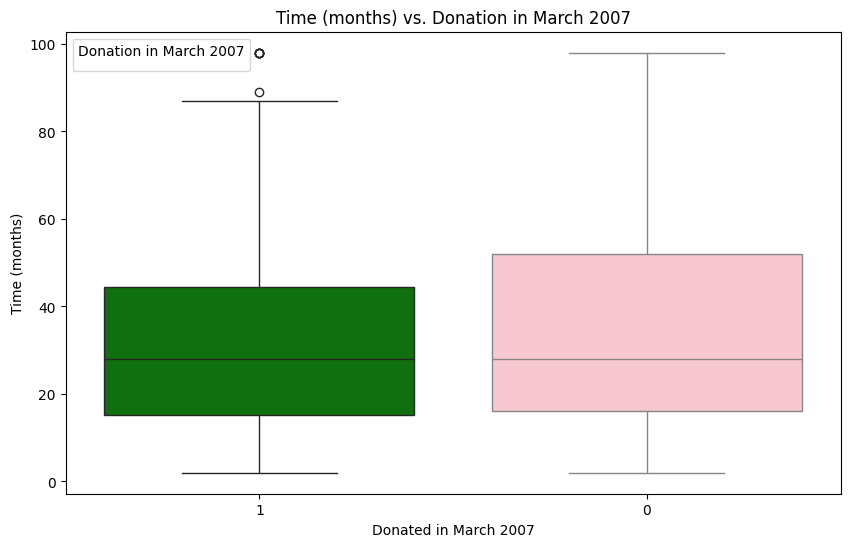

In [24]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the boxplot for donated in March 2007 (green)
sns.boxplot(x='whether he/she donated blood in March 2007', y='Time (months)', data=df[df['whether he/she donated blood in March 2007'] == 1], color='green', ax=ax)

# Plot the boxplot for not donated in March 2007 (pink)
sns.boxplot(x='whether he/she donated blood in March 2007', y='Time (months)', data=df[df['whether he/she donated blood in March 2007'] == 0], color='pink', ax=ax)

# Add title, labels and legend
ax.set_title('Time (months) vs. Donation in March 2007')
ax.set_xlabel('Donated in March 2007')
ax.set_ylabel('Time (months)')
ax.legend(title='Donation in March 2007')

# Show the plot
plt.show()


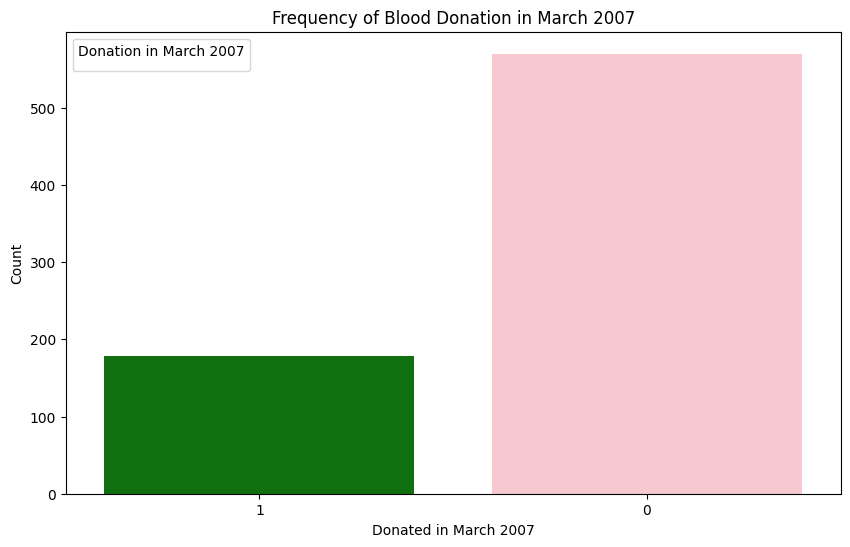

In [25]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the countplot for donated in March 2007 (green)
sns.countplot(x='whether he/she donated blood in March 2007', data=df[df['whether he/she donated blood in March 2007'] == 1], color='green', ax=ax)

# Plot the countplot for not donated in March 2007 (pink)
sns.countplot(x='whether he/she donated blood in March 2007', data=df[df['whether he/she donated blood in March 2007'] == 0], color='pink', ax=ax)

# Add title, labels and legend
ax.set_title('Frequency of Blood Donation in March 2007')
ax.set_xlabel('Donated in March 2007')
ax.set_ylabel('Count')
ax.legend(title='Donation in March 2007')

# Show the plot
plt.show()


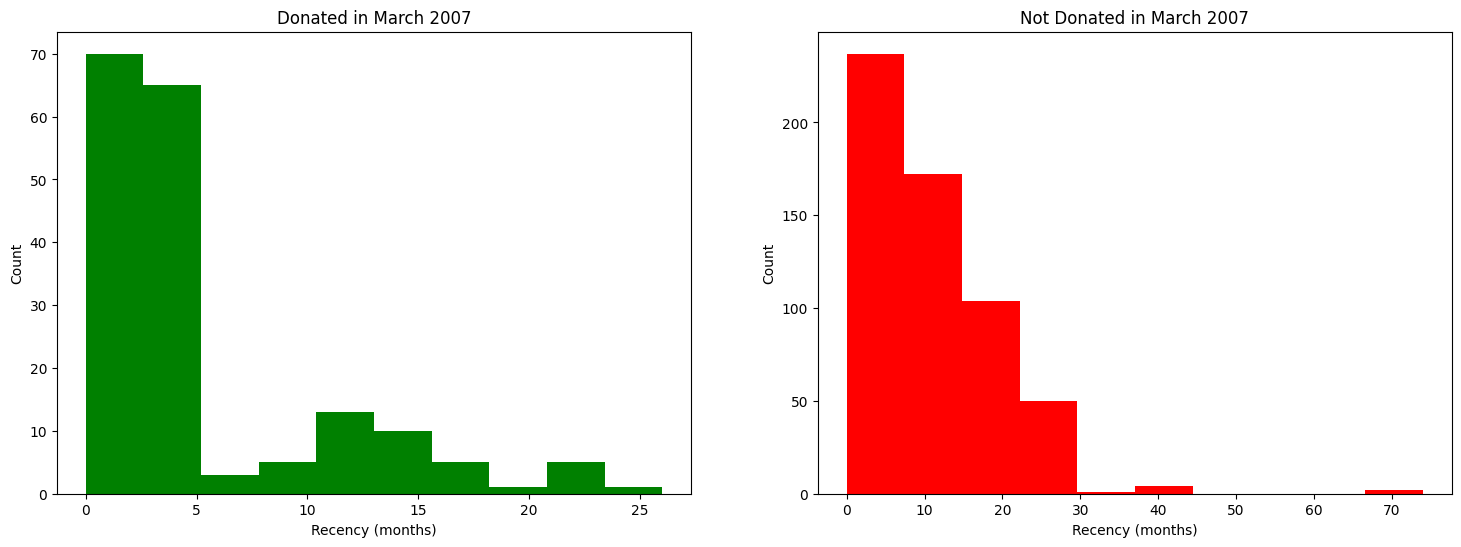

In [26]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the histogram for donated in March 2007
axes[0].hist(df[df['whether he/she donated blood in March 2007'] == 1]['Recency (months)'], bins=10, color='green')
axes[0].set_title('Donated in March 2007')
axes[0].set_xlabel('Recency (months)')
axes[0].set_ylabel('Count')

# Plot the histogram for not donated in March 2007
axes[1].hist(df[df['whether he/she donated blood in March 2007'] == 0]['Recency (months)'], bins=10, color='red')
axes[1].set_title('Not Donated in March 2007')
axes[1].set_xlabel('Recency (months)')
axes[1].set_ylabel('Count')

plt.show()


In [27]:
X = df.drop('whether he/she donated blood in March 2007', axis=1)
y = df['whether he/she donated blood in March 2007']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model = LogisticRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[110   3]
 [ 33   4]]
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       113
           1       0.57      0.11      0.18        37

    accuracy                           0.76       150
   macro avg       0.67      0.54      0.52       150
weighted avg       0.72      0.76      0.69       150



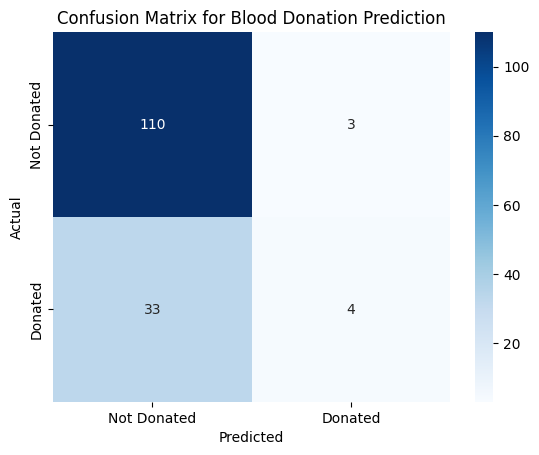

In [28]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap visualization of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['Not Donated', 'Donated'], yticklabels=['Not Donated', 'Donated'])

# Set labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Blood Donation Prediction")

# Display the plot
plt.show()


In [29]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


y_rf_pred = rf_model.predict(X_test)


print(confusion_matrix(y_test, y_rf_pred))
print(classification_report(y_test, y_rf_pred))


[[101  12]
 [ 28   9]]
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       113
           1       0.43      0.24      0.31        37

    accuracy                           0.73       150
   macro avg       0.61      0.57      0.57       150
weighted avg       0.70      0.73      0.71       150



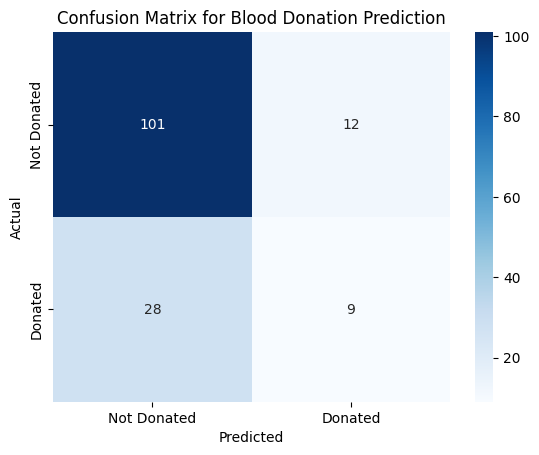

In [30]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_rf_pred)

# Create a heatmap visualization of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['Not Donated', 'Donated'], yticklabels=['Not Donated', 'Donated'])

# Set labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Blood Donation Prediction")

# Display the plot
plt.show()

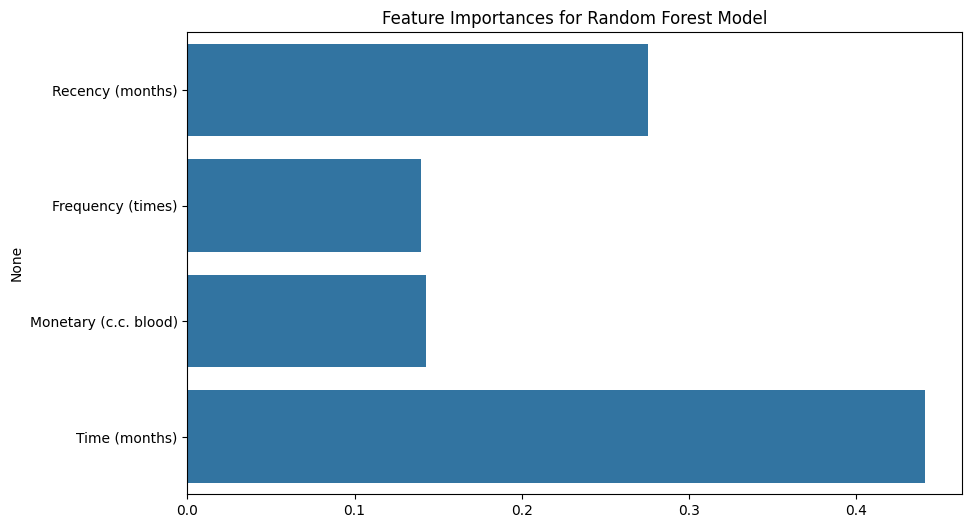

In [31]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=X.columns)
plt.title('Feature Importances for Random Forest Model')
plt.show()


In [32]:
df.columns = ['Recency (months)', 'Frequency (times)', 'Monetary (c.c. blood)', 'Time (months)', 'whether he/she donated blood in March 2007']


X = df.drop('whether he/she donated blood in March 2007', axis=1)
y = df['whether he/she donated blood in March 2007']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}


model = LogisticRegression()


grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=1, verbose=1)
grid_search.fit(X_train, y_train)


results = pd.DataFrame(grid_search.cv_results_)


results = results[['param_penalty', 'param_C', 'param_solver', 'param_max_iter', 'mean_test_score', 'std_test_score', 'rank_test_score']]


print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)


print(results)


results.to_csv('grid_search_results.csv', index=False)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters found:  {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy:  0.7776330532212885
   param_penalty  param_C param_solver  param_max_iter  mean_test_score  \
0             l1     0.01    liblinear             100         0.764216   
1             l1     0.01         saga             100         0.764216   
2             l2     0.01    liblinear             100         0.777619   
3             l2     0.01         saga             100         0.770924   
4             l1     0.01    liblinear             200         0.764216   
5             l1     0.01         saga             200         0.764216   
6             l2     0.01    liblinear             200         0.777619   
7             l2     0.01         saga             200         0.770924   
8             l1     0.01    liblinear             300         0.764216   
9             l1     0.01         saga             300       

In [33]:
X = df.drop('whether he/she donated blood in March 2007', axis=1)
y = df['whether he/she donated blood in March 2007']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}


model = LogisticRegression()


grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=1, verbose=1)
grid_search.fit(X_train, y_train)


results = pd.DataFrame(grid_search.cv_results_)


test_accuracies = []

for params in results['params']:
    model.set_params(**params)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

results['test_accuracy'] = test_accuracies


results = results[['param_penalty', 'param_C', 'param_solver', 'param_max_iter', 'mean_test_score', 'std_test_score', 'rank_test_score', 'test_accuracy']]


print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)


results.to_csv('grid_search_results_with_test_accuracy.csv', index=False)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters found:  {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy:  0.7776330532212885


In [34]:
grid_search_results_with_test_accuracy = pd.read_csv( 'grid_search_results_with_test_accuracy.csv')
grid_search_results_with_test_accuracy.head()

,param_penalty,param_C,param_solver,param_max_iter,mean_test_score,std_test_score,rank_test_score,test_accuracy
0,l1,0.01,liblinear,100,0.764216,0.003069,55,0.753333
1,l1,0.01,saga,100,0.764216,0.003069,55,0.753333
2,l2,0.01,liblinear,100,0.777619,0.013117,16,0.773333
3,l2,0.01,saga,100,0.770924,0.007876,49,0.760000
4,l1,0.01,liblinear,200,0.764216,0.003069,55,0.753333


# Brute-force without column Monetary (c.c. blood)

In [35]:
X = df.drop(['whether he/she donated blood in March 2007','Monetary (c.c. blood)'], axis=1)
y = df['whether he/she donated blood in March 2007']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}


model = LogisticRegression()


grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=1, verbose=1)
grid_search.fit(X_train, y_train)


results = pd.DataFrame(grid_search.cv_results_)


test_accuracies = []

for params in results['params']:
    model.set_params(**params)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

results['test_accuracy'] = test_accuracies


results = results[['param_penalty', 'param_C', 'param_solver', 'param_max_iter', 'mean_test_score', 'std_test_score', 'rank_test_score', 'test_accuracy']]


print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)




Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters found:  {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy:  0.7776330532212885


#Drcision tree hyperparameter tuning

In [37]:
X = df.drop('whether he/she donated blood in March 2007', axis=1)
y = df['whether he/she donated blood in March 2007']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [38]:
fixed_params = {
    'n_estimators': 100,
    'criterion': 'log_loss',
    'min_samples_split': 20,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'bootstrap': True,
    'random_state': 42
}


max_depth_values = [None, 1,5,6,7,8,9, 10, 15, 20, 25, 30]


accuracies = []


for max_depth in max_depth_values:
    params = fixed_params.copy()
    params['max_depth'] = max_depth
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    accuracies.append(accuracy)


for depth, acc in zip(max_depth_values, accuracies):
    print(f"Max Depth: {depth}, Test Accuracy: {acc:.4f}")


Max Depth: None, Test Accuracy: 0.7933
Max Depth: 1, Test Accuracy: 0.7533
Max Depth: 5, Test Accuracy: 0.8067
Max Depth: 6, Test Accuracy: 0.7933
Max Depth: 7, Test Accuracy: 0.7933
Max Depth: 8, Test Accuracy: 0.7933
Max Depth: 9, Test Accuracy: 0.8000
Max Depth: 10, Test Accuracy: 0.7867
Max Depth: 15, Test Accuracy: 0.7933
Max Depth: 20, Test Accuracy: 0.7933
Max Depth: 25, Test Accuracy: 0.7933
Max Depth: 30, Test Accuracy: 0.7933


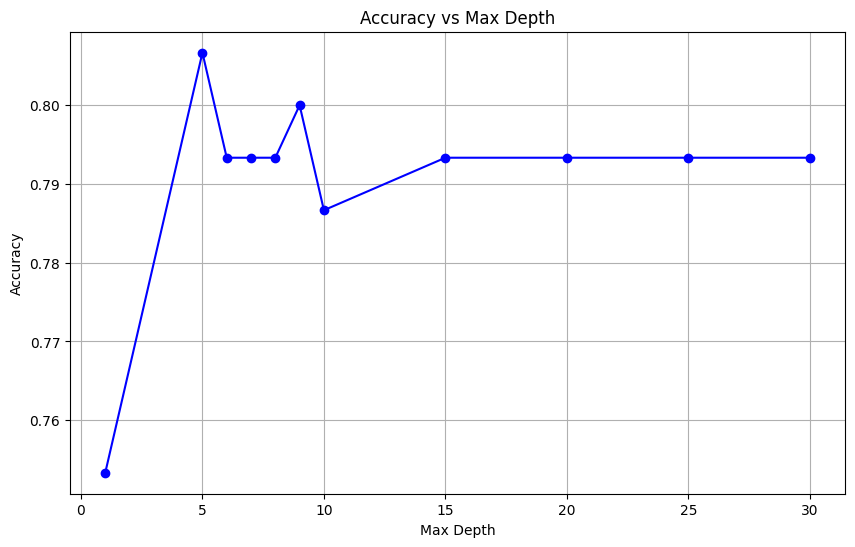

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [40]:
fixed_params = {
    'max_depth': 5,
    'criterion': 'log_loss',
    'min_samples_split': 20,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'bootstrap': True,
    'random_state': 42
}


n_estimators_values = [1, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]


accuracies = []


for n_estimators in n_estimators_values:
    params = fixed_params.copy()
    params['n_estimators'] = n_estimators
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    accuracies.append(accuracy)

# نمایش نتایج
for n, acc in zip(n_estimators_values, accuracies):
    print(f"Max n_estimators: {n}, Test Accuracy: {acc:.4f}")

Max n_estimators: 1, Test Accuracy: 0.7800
Max n_estimators: 5, Test Accuracy: 0.7733
Max n_estimators: 6, Test Accuracy: 0.7800
Max n_estimators: 7, Test Accuracy: 0.7933
Max n_estimators: 8, Test Accuracy: 0.7800
Max n_estimators: 9, Test Accuracy: 0.7800
Max n_estimators: 10, Test Accuracy: 0.7800
Max n_estimators: 15, Test Accuracy: 0.7867
Max n_estimators: 20, Test Accuracy: 0.8067
Max n_estimators: 25, Test Accuracy: 0.8067
Max n_estimators: 30, Test Accuracy: 0.8067
Max n_estimators: 40, Test Accuracy: 0.8000
Max n_estimators: 50, Test Accuracy: 0.8000
Max n_estimators: 60, Test Accuracy: 0.8000
Max n_estimators: 70, Test Accuracy: 0.8067
Max n_estimators: 80, Test Accuracy: 0.8067
Max n_estimators: 90, Test Accuracy: 0.8067
Max n_estimators: 100, Test Accuracy: 0.8067


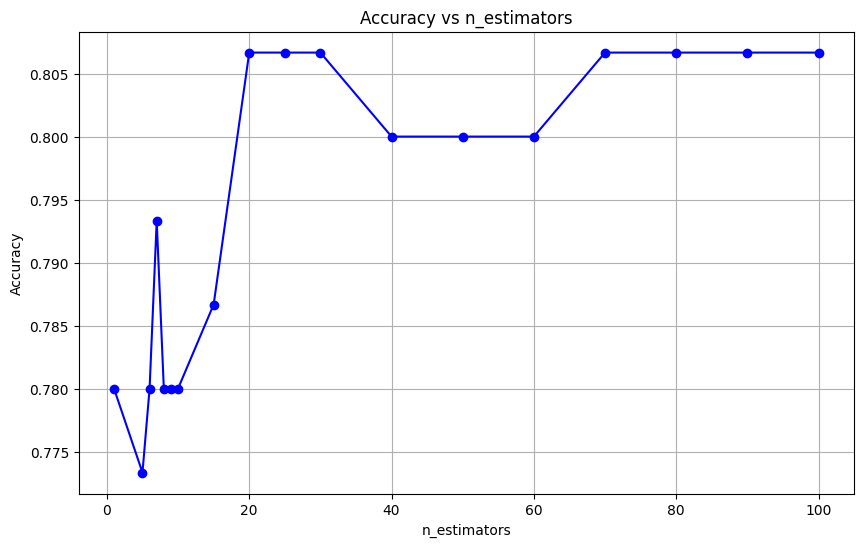

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [42]:
fixed_params = {
    'n_estimators': 80,
    'max_depth': 5,
    'criterion': 'log_loss',
    'min_samples_leaf': 10,
    'max_features': 'log2',
    'bootstrap': True,
    'random_state': 42
}


min_samples_split_values = [2, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]


accuracies = []


for min_samples_split in min_samples_split_values:
    params = fixed_params.copy()
    params['min_samples_split'] = min_samples_split
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    accuracies.append(accuracy)


for min_samples_split, acc in zip(min_samples_split_values, accuracies):
    print(f"min_samples_split: {min_samples_split}, Test Accuracy: {acc:.4f}")

min_samples_split: 2, Test Accuracy: 0.8133
min_samples_split: 5, Test Accuracy: 0.8133
min_samples_split: 6, Test Accuracy: 0.8133
min_samples_split: 7, Test Accuracy: 0.8133
min_samples_split: 8, Test Accuracy: 0.8133
min_samples_split: 9, Test Accuracy: 0.8133
min_samples_split: 10, Test Accuracy: 0.8133
min_samples_split: 15, Test Accuracy: 0.8133
min_samples_split: 20, Test Accuracy: 0.8133
min_samples_split: 25, Test Accuracy: 0.8000
min_samples_split: 30, Test Accuracy: 0.8000
min_samples_split: 40, Test Accuracy: 0.7733
min_samples_split: 50, Test Accuracy: 0.7800
min_samples_split: 60, Test Accuracy: 0.7800
min_samples_split: 70, Test Accuracy: 0.7733
min_samples_split: 80, Test Accuracy: 0.7600
min_samples_split: 90, Test Accuracy: 0.7533
min_samples_split: 100, Test Accuracy: 0.7467


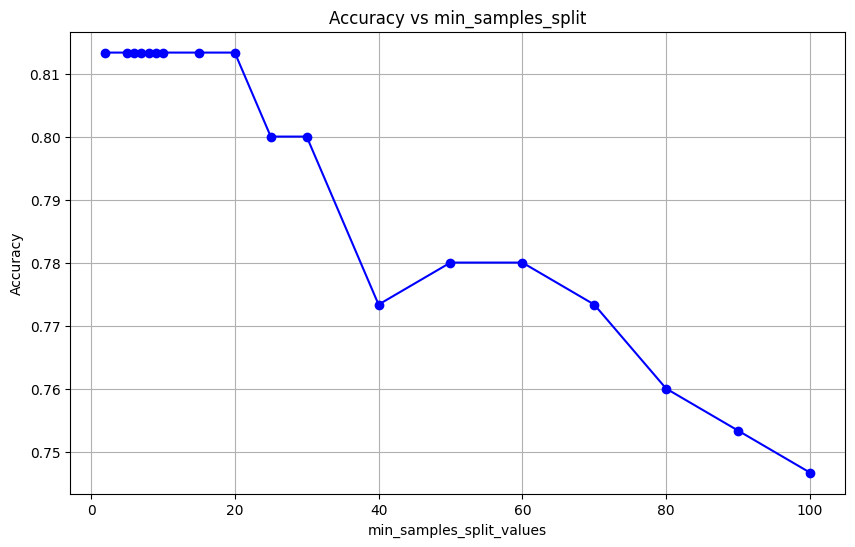

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(min_samples_split_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs min_samples_split')
plt.xlabel('min_samples_split_values')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [44]:
fixed_params = {
    'n_estimators': 80,
    'max_depth': 5,
    'criterion': 'log_loss',
    'min_samples_split': 20,
    'max_features': 'log2',
    'bootstrap': True,
    'random_state': 42
}


min_samples_leafـvalues = [2, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]


accuracies = []


for min_samples_leaf in min_samples_leafـvalues:
    params = fixed_params.copy()
    params['min_samples_leaf'] = min_samples_leaf
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    accuracies.append(accuracy)

for min_samples_leaf, acc in zip(min_samples_leafـvalues, accuracies):
    print(f"min_samples_leaf: {min_samples_leaf}, Test Accuracy: {acc:.4f}")

min_samples_leaf: 2, Test Accuracy: 0.8067
min_samples_leaf: 5, Test Accuracy: 0.8067
min_samples_leaf: 6, Test Accuracy: 0.8067
min_samples_leaf: 7, Test Accuracy: 0.8000
min_samples_leaf: 8, Test Accuracy: 0.8067
min_samples_leaf: 9, Test Accuracy: 0.8133
min_samples_leaf: 10, Test Accuracy: 0.8133
min_samples_leaf: 15, Test Accuracy: 0.7867
min_samples_leaf: 20, Test Accuracy: 0.7867
min_samples_leaf: 25, Test Accuracy: 0.7667
min_samples_leaf: 30, Test Accuracy: 0.7667
min_samples_leaf: 40, Test Accuracy: 0.7533
min_samples_leaf: 50, Test Accuracy: 0.7533
min_samples_leaf: 60, Test Accuracy: 0.7533
min_samples_leaf: 70, Test Accuracy: 0.7533
min_samples_leaf: 80, Test Accuracy: 0.7533
min_samples_leaf: 90, Test Accuracy: 0.7533
min_samples_leaf: 100, Test Accuracy: 0.7533


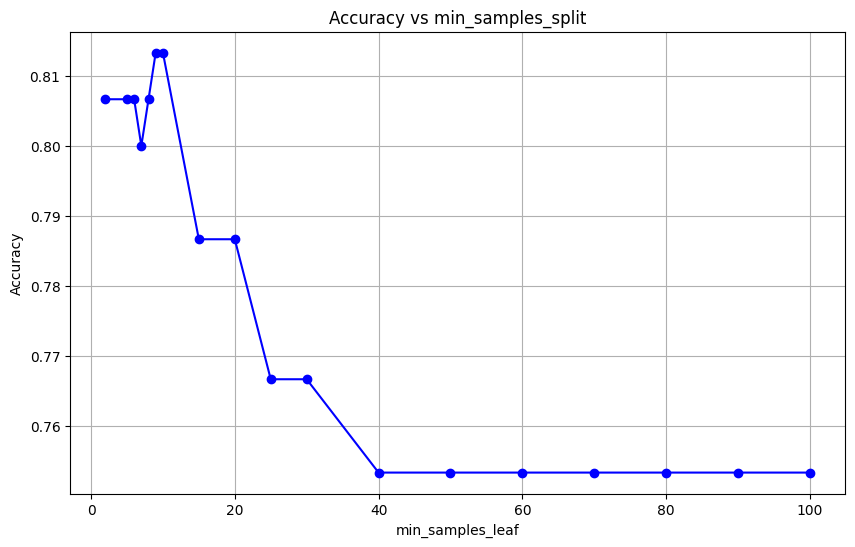

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(min_samples_leafـvalues, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs min_samples_split')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [46]:
fixed_params = {
    'n_estimators': 80,
    'max_depth': 5,
    'criterion': 'log_loss',
    'min_samples_split': 20,
    'min_samples_leaf' : 10,
    'max_features': 'log2',
    'bootstrap': True,
    'random_state': 42
}

params = fixed_params.copy()
model = RandomForestClassifier(**params)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8133


In [47]:
# Perform cross-validation with 5 folds
scores = cross_val_score(model, X_train, y_train, cv=5)

# Print the mean and standard deviation of the accuracy scores
print("Cross-Validation Accuracy Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())


Cross-Validation Accuracy Scores: [0.75833333 0.75833333 0.80833333 0.81512605 0.77310924]
Mean Accuracy: 0.7826470588235294
Standard Deviation: 0.024445670394290547


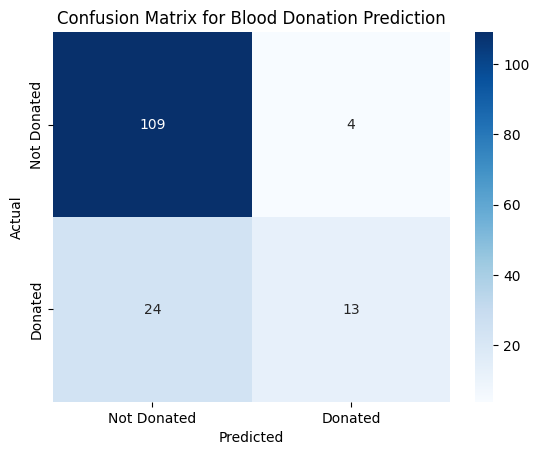

In [48]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create a heatmap visualization of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['Not Donated', 'Donated'], yticklabels=['Not Donated', 'Donated'])

# Set labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Blood Donation Prediction")

# Display the plot
plt.show()


# Train model without Monetary (c.c. blood) column

In [49]:
X = df.drop(['whether he/she donated blood in March 2007', 'Monetary (c.c. blood)', 'Time (months)'], axis=1)
y = df['whether he/she donated blood in March 2007']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [50]:
fixed_params = {
    'n_estimators': 80,
    'max_depth': 5,
    'criterion': 'log_loss',
    'min_samples_split': 20,
    'min_samples_leaf' : 10,
    'max_features': 'log2',
    'bootstrap': True,
    'random_state': 42
}



params = fixed_params.copy()
model = RandomForestClassifier(**params)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7533


# SVM

In [51]:
X = df.drop(['whether he/she donated blood in March 2007', 'Monetary (c.c. blood)'], axis=1)
y = df['whether he/she donated blood in March 2007']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [52]:
svm_model = SVC(kernel='poly', random_state=42)


svm_model.fit(X_train, y_train)


y_pred = svm_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Accuracy: 0.7600
Confusion Matrix:
[[112   1]
 [ 35   2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.99      0.86       113
           1       0.67      0.05      0.10        37

    accuracy                           0.76       150
   macro avg       0.71      0.52      0.48       150
weighted avg       0.74      0.76      0.67       150



# BruteForce for SVM hyperparameter

In [53]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}


svm_model = SVC(random_state=42)


grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.7893
Accuracy: 0.7600
Confusion Matrix:
[[108   5]
 [ 31   6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86       113
           1       0.55      0.16      0.25        37

    accuracy                           0.76       150
   macro avg       0.66      0.56      0.55       150
weighted avg       0.72      0.76      0.71       150



Test Accuracy: 0.7400
Confusion Matrix:
[[102  11]
 [ 28   9]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       113
           1       0.45      0.24      0.32        37

    accuracy                           0.74       150
   macro avg       0.62      0.57      0.58       150
weighted avg       0.70      0.74      0.71       150



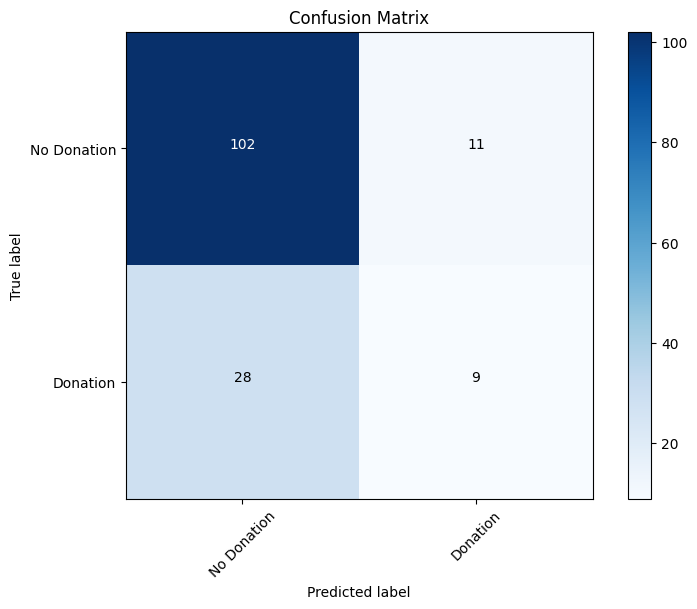

In [54]:
X = df.drop(['whether he/she donated blood in March 2007', 'Monetary (c.c. blood)'], axis=1)
y = df['whether he/she donated blood in March 2007']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


fixed_params = {
    'n_estimators': 80,
    'max_depth': 5,
    'criterion': 'log_loss',
    'min_samples_split': 20,
    'min_samples_leaf': 10,
    'max_features': 'log2',
    'bootstrap': True,
    'random_state': 42
}


params = fixed_params.copy()
model = RandomForestClassifier(**params)
model.fit(X_train_pca, y_train)


y_test_pred = model.predict(X_test_pca)


accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_test_pred)
print("Classification Report:")
print(class_report)


plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(len(conf_matrix))
plt.xticks(tick_marks, ['No Donation', 'Donation'], rotation=45)
plt.yticks(tick_marks, ['No Donation', 'Donation'])

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# KNN

In [55]:
data = df.copy()


data.columns = ["Recency", "Frequency", "Monetary", "Time", "Donated"]


X = data.drop(["Donated", 'Monetary', 'Time'], axis=1)
y = data["Donated"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


knn = KNeighborsClassifier(n_neighbors=4)


knn.fit(X_train, y_train)


y_pred = knn.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7866666666666666
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       113
           1       0.63      0.32      0.43        37

    accuracy                           0.79       150
   macro avg       0.72      0.63      0.65       150
weighted avg       0.77      0.79      0.76       150



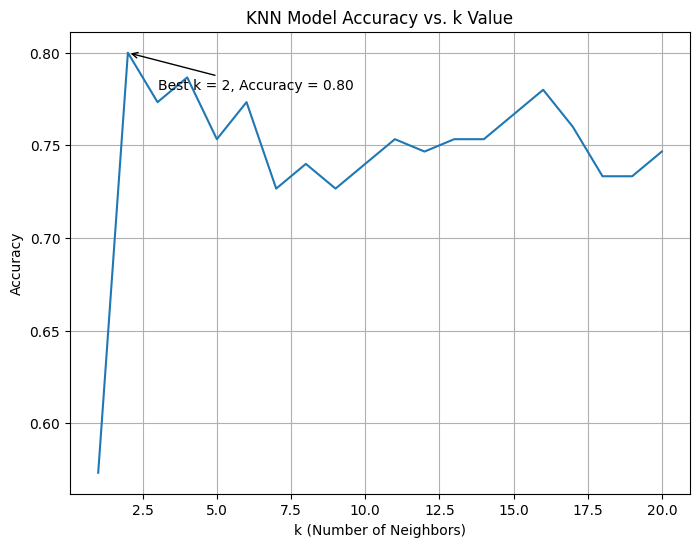

In [56]:
data = df.copy()


data.columns = ["Recency", "Frequency", "Monetary", "Time", "Donated"]


X = data.drop(["Donated", 'Monetary', 'Time'], axis=1)
y = data["Donated"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


k_values = range(1, 21)  # Example k values from 1 to 20
accuracies = []
best_accuracy = 0
best_k = 0
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracies)
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('KNN Model Accuracy vs. k Value')
plt.grid(True)


plt.annotate(f'Best k = {best_k}, Accuracy = {best_accuracy:.2f}',
             xy=(best_k, best_accuracy),
             xytext=(best_k + 1, best_accuracy - 0.02),  # Adjust position of annotation
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()



# PCA


Variance Ratios: [0.58660608 0.41339392]

sum Variance Ratios: 0.9999999999999999


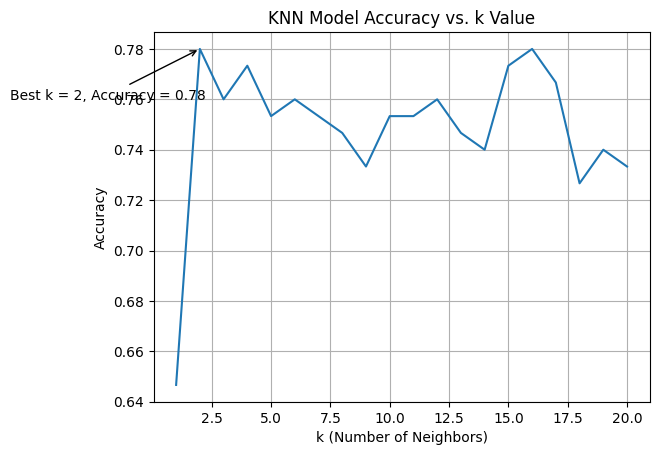

In [57]:
X = df.drop(['whether he/she donated blood in March 2007', 'Monetary (c.c. blood)', "Time (months)"], axis=1)
y = df['whether he/she donated blood in March 2007']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled) # Fit PCA to the training data first
X_test_pca = pca.transform(X_test_scaled)

variance_ratios = pca.explained_variance_ratio_ # Now you can access explained_variance_ratio_
print("Variance Ratios:", variance_ratios)
print("\nsum Variance Ratios:", sum(variance_ratios))



from sklearn.neighbors import KNeighborsClassifier




k_values = range(1, 21)  # Example k values from 1 to 20
accuracies = []
best_accuracy = 0
best_k = 0
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_pca, y_train)
    y_test_pred = model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_test_pred)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

# Plot accuracy versus k value

#plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracies)
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('KNN Model Accuracy vs. k Value')
plt.grid(True)

# Annotate the plot with the best k and accuracy
plt.annotate(f'Best k = {best_k}, Accuracy = {best_accuracy:.2f}',
             xy=(best_k, best_accuracy),
             xytext=(best_k - 8, best_accuracy - 0.02),  # Adjust position of annotation
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()



#processing outlier's

In [58]:
df_out_remove = df.copy()
Q1 = df_out_remove['Frequency (times)'].quantile(0.25)
Q3 = df_out_remove['Frequency (times)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
num_outliers = df_out_remove[
    (df_out_remove['Frequency (times)'] < lower_bound) |
    (df_out_remove['Frequency (times)'] > upper_bound)
].shape[0]
print("Number of outliers:", num_outliers)
df_out_remove = df_out_remove[(df_out_remove['Frequency (times)'] >= lower_bound) & (df_out_remove['Frequency (times)'] <= upper_bound)]


Number of outliers: 45


In [59]:
df_out_remove.info()

<class 'pandas.core.frame.DataFrame'>
Index: 703 entries, 1 to 747
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Recency (months)                            703 non-null    int64
 1   Frequency (times)                           703 non-null    int64
 2   Monetary (c.c. blood)                       703 non-null    int64
 3   Time (months)                               703 non-null    int64
 4   whether he/she donated blood in March 2007  703 non-null    int64
dtypes: int64(5)
memory usage: 33.0 KB


In [60]:
Q1 = df_out_remove['Monetary (c.c. blood)'].quantile(0.25)
Q3 = df_out_remove['Monetary (c.c. blood)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
num_outliers = df_out_remove[
    (df_out_remove['Monetary (c.c. blood)'] < lower_bound) |
    (df_out_remove['Monetary (c.c. blood)'] > upper_bound)
].shape[0]
print("Number of outliers:", num_outliers)
df_out_remove = df_out_remove[(df_out_remove['Monetary (c.c. blood)'] >= lower_bound) & (df_out_remove['Monetary (c.c. blood)'] <= upper_bound)]


Number of outliers: 22


In [61]:
df_out_remove.info()

<class 'pandas.core.frame.DataFrame'>
Index: 681 entries, 5 to 747
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Recency (months)                            681 non-null    int64
 1   Frequency (times)                           681 non-null    int64
 2   Monetary (c.c. blood)                       681 non-null    int64
 3   Time (months)                               681 non-null    int64
 4   whether he/she donated blood in March 2007  681 non-null    int64
dtypes: int64(5)
memory usage: 31.9 KB


In [62]:
Q1 = df_out_remove['Recency (months)'].quantile(0.25)
Q3 = df_out_remove['Recency (months)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
num_outliers = df_out_remove[
    (df_out_remove['Recency (months)'] < lower_bound) |
    (df_out_remove['Recency (months)'] > upper_bound)
].shape[0]
print("Number of outliers:", num_outliers)
df_out_remove = df_out_remove[(df_out_remove['Recency (months)'] >= lower_bound) & (df_out_remove['Recency (months)'] <= upper_bound)]


Number of outliers: 7


In [63]:
df.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [64]:
df_mahala = df.copy()

In [65]:
# Assuming 'X' contains your feature columns
X = df_mahala[['Frequency (times)', 'Monetary (c.c. blood)',  'Recency (months)']]

# Calculate the Mahalanobis distance
# Convert the mean Series to a NumPy array and then reshape
mahalanobis_distances = distance.cdist(X.to_numpy(),
                                     np.array(X.mean(axis=0)).reshape(1, -1),
                                     'mahalanobis')[:, 0]

# Add the Mahalanobis distances as a new column to the DataFrame
df_mahala['Mahalanobis'] = mahalanobis_distances

In [66]:
# Set a threshold for outlier detection (e.g., 3 standard deviations)
threshold = 3

# Identify outliers
outliers = df_mahala[df_mahala['Mahalanobis'] > threshold]

print("Outliers:")
print(outliers)

Outliers:
     Recency (months)  Frequency (times)  Monetary (c.c. blood)  \
0                   2                 50                  12500   
4                   1                 24                   6000   
9                   5                 46                  11500   
115                11                 24                   6000   
341                23                 38                   9500   
495                35                  3                    750   
496                38                  1                    250   
497                38                  1                    250   
498                40                  1                    250   
499                74                  1                    250   
500                 2                 43                  10750   
502                 2                 34                   8500   
503                 2                 44                  11000   
504                 0                 26            

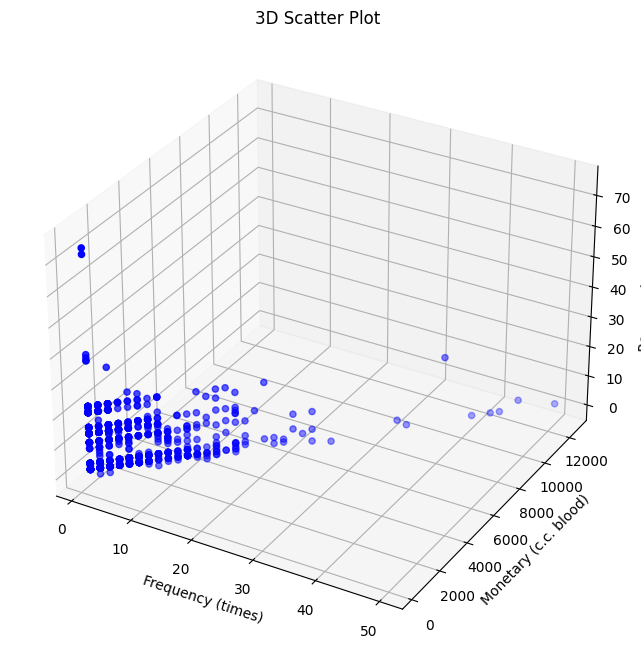

In [97]:
# Create a figure and an axes object for the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract the data for the 3D plot
x = df['Frequency (times)']
y = df['Monetary (c.c. blood)']
z = df['Recency (months)']

# Plot the data points in 3D
ax.scatter(x, y, z, c='blue', marker='o')

# Set the axis labels
ax.set_xlabel('Frequency (times)')
ax.set_ylabel('Monetary (c.c. blood)')
ax.set_zlabel('Recency (months)')

# Set the title of the plot
ax.set_title('3D Scatter Plot')

# Display the plot
plt.show()

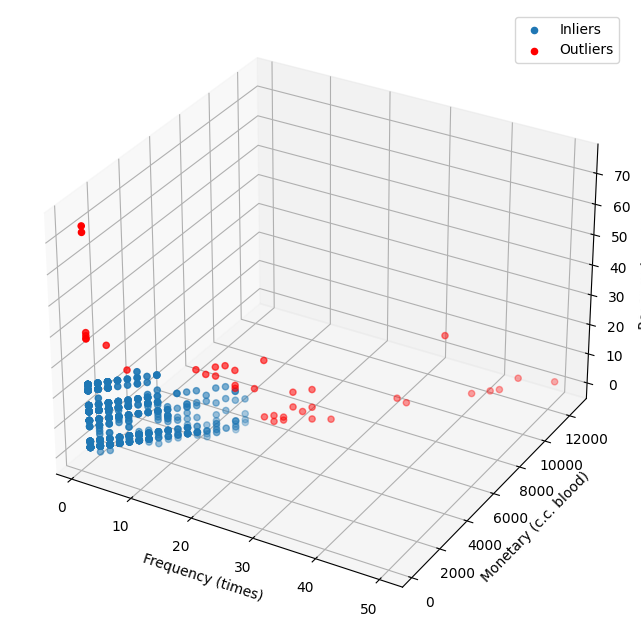

In [133]:
x = df[['Frequency (times)', 'Monetary (c.c. blood)', 'Recency (months)']].values
cov = np.cov(x, rowvar=False)
inv_cov = np.linalg.inv(cov)

mean = np.mean(x, axis=0)
mahalanobis_distances = [distance.mahalanobis(point, mean, inv_cov) for point in x]

threshold = np.percentile(mahalanobis_distances, 95)  # Adjust the percentile as needed
outlier_indices = mahalanobis_distances > threshold
outliers = x[outlier_indices]
inliers = x[~outlier_indices] # Select inliers

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot inliers and outliers separately

ax.scatter(inliers[:, 0], inliers[:, 1], inliers[:, 2], label='Inliers')
ax.scatter(outliers[:, 0], outliers[:, 1], outliers[:, 2], c='r', label='Outliers')
ax.set_xlabel('Frequency (times)')
ax.set_ylabel('Monetary (c.c. blood)')
ax.set_zlabel('Recency (months)')
ax.legend()
plt.show()

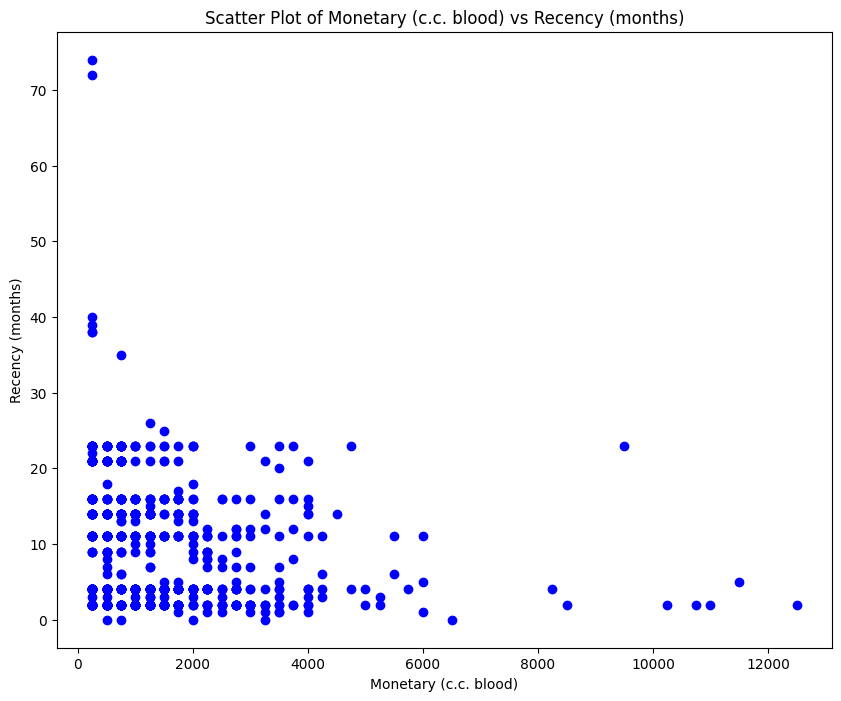

In [69]:
# Extract the data for the scatter plot
x = df['Monetary (c.c. blood)']
y = df['Recency (months)']

# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data points as a scatter plot
ax.scatter(x, y, color='blue', marker='o')

# Set the axis labels
ax.set_xlabel('Monetary (c.c. blood)')
ax.set_ylabel('Recency (months)')

# Set the title of the plot
ax.set_title('Scatter Plot of Monetary (c.c. blood) vs Recency (months)')

# Show the plot
plt.show()


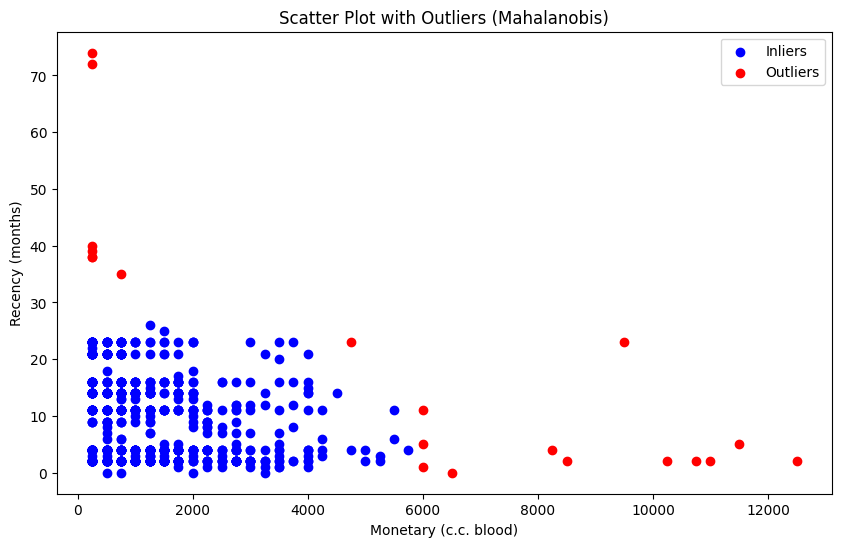

In [70]:
# Assuming 'df' is your DataFrame
X = df[['Monetary (c.c. blood)', 'Recency (months)']]

# Calculate the Mahalanobis distance
# Convert the mean Series to a NumPy array and then reshape
mahalanobis_distances = distance.cdist(X.to_numpy(),
                                     np.array(X.mean(axis=0)).reshape(1, -1),
                                     'mahalanobis')[:, 0]

# Set a threshold for outlier detection
threshold = 3  # Example threshold, adjust as needed

# Identify outliers
outlier_indices = mahalanobis_distances > threshold

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X[~outlier_indices]['Monetary (c.c. blood)'], X[~outlier_indices]['Recency (months)'], label='Inliers', c='blue')
plt.scatter(X[outlier_indices]['Monetary (c.c. blood)'], X[outlier_indices]['Recency (months)'], label='Outliers', c='red')

plt.xlabel('Monetary (c.c. blood)')
plt.ylabel('Recency (months)')
plt.title('Scatter Plot with Outliers (Mahalanobis)')
plt.legend()
plt.show()

In [71]:
df_mahala_no_outliers = df_mahala[~outlier_indices]

# Verify the shape of the new DataFrame
print("Shape of original DataFrame:", df_mahala.shape)
print("Shape of DataFrame without outliers:", df_mahala_no_outliers.shape)

Shape of original DataFrame: (748, 6)
Shape of DataFrame without outliers: (728, 6)


In [72]:
df_mahala_no_outliers.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007,Mahalanobis
1,0,13,3250,28,1,1.672053
2,1,16,4000,35,1,2.110355
3,2,20,5000,45,1,2.726207
5,4,4,1000,4,0,0.801544
6,2,7,1750,14,1,0.935054


In [73]:
df_mahala_no_outliers = df_mahala_no_outliers.drop(['Monetary (c.c. blood)', 'Time (months)', 'Mahalanobis'], axis=1)
df_mahala_no_outliers.head()

,Recency (months),Frequency (times),whether he/she donated blood in March 2007
1,0,13,1
2,1,16,1
3,2,20,1
5,4,4,0
6,2,7,1


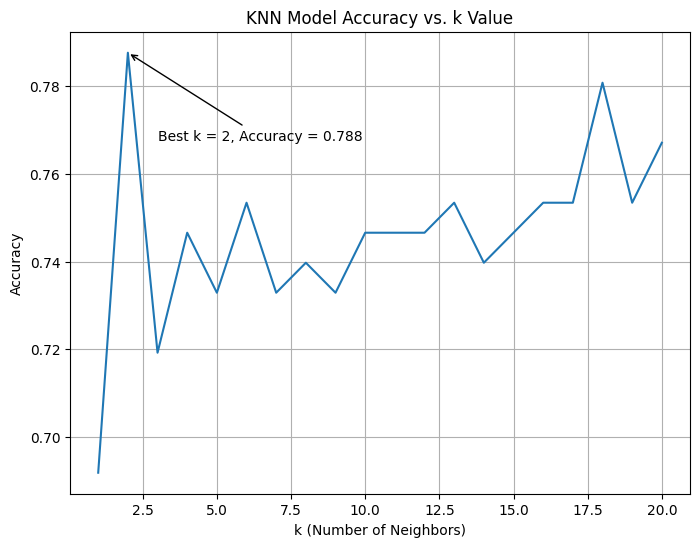

In [74]:
# Split the data into training and testing sets
X = df_mahala_no_outliers.drop('whether he/she donated blood in March 2007', axis=1)
y = df_mahala_no_outliers['whether he/she donated blood in March 2007']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)  #  random_state=10

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

k_values = range(1, 21)  # Example k values from 1 to 20
accuracies = []
best_accuracy = 0
best_k = 0
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k




plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracies)
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('KNN Model Accuracy vs. k Value')
plt.grid(True)

# Annotate the plot with the best k and accuracy
plt.annotate(f'Best k = {best_k}, Accuracy = {best_accuracy:.3f}',
             xy=(best_k, best_accuracy),
             xytext=(best_k + 1, best_accuracy - 0.02),  # Adjust position of annotation
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()


In [75]:
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train)

# Perform cross-validation with 5 folds
scores = cross_val_score(model, X_train, y_train, cv=5)

# Print the mean and standard deviation of the accuracy scores
print("Cross-Validation Accuracy Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())


Cross-Validation Accuracy Scores: [0.72649573 0.75213675 0.73275862 0.77586207 0.75      ]
Mean Accuracy: 0.7474506336575303
Standard Deviation: 0.017266337252685515


In [76]:
X = df_mahala_no_outliers.drop('whether he/she donated blood in March 2007' , axis=1)
y = df_mahala_no_outliers['whether he/she donated blood in March 2007']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [77]:
fixed_params = {
    'n_estimators': 100,
    'criterion': 'log_loss',
    'min_samples_split': 20,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'bootstrap': True,
    'random_state': 42
}


max_depth_values = [None, 1,5,6,7,8,9, 10, 15, 20, 25, 30]


accuracies = []


for max_depth in max_depth_values:
    params = fixed_params.copy()
    params['max_depth'] = max_depth
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    accuracies.append(accuracy)


for depth, acc in zip(max_depth_values, accuracies):
    print(f"Max Depth: {depth}, Test Accuracy: {acc:.4f}")


Max Depth: None, Test Accuracy: 0.7877
Max Depth: 1, Test Accuracy: 0.7603
Max Depth: 5, Test Accuracy: 0.7671
Max Depth: 6, Test Accuracy: 0.7740
Max Depth: 7, Test Accuracy: 0.7945
Max Depth: 8, Test Accuracy: 0.8014
Max Depth: 9, Test Accuracy: 0.7877
Max Depth: 10, Test Accuracy: 0.7877
Max Depth: 15, Test Accuracy: 0.7877
Max Depth: 20, Test Accuracy: 0.7877
Max Depth: 25, Test Accuracy: 0.7877
Max Depth: 30, Test Accuracy: 0.7877


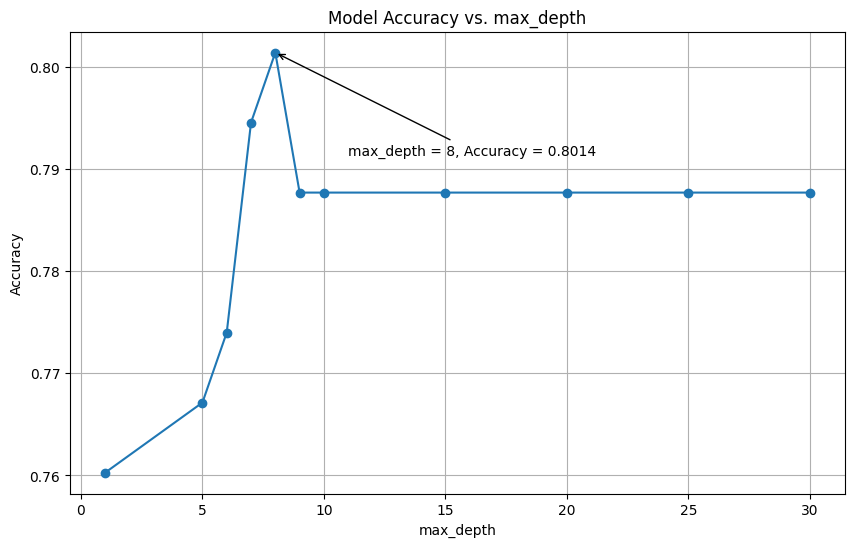

In [78]:
# Plot max_depth_values vs accuracies
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. max_depth')
plt.grid(True)

# Find the index of the maximum accuracy
max_accuracy_index = np.argmax(accuracies)

# Draw an arrow to the maximum accuracy point
plt.annotate(f'max_depth = {max_depth_values[max_accuracy_index]}, Accuracy = {accuracies[max_accuracy_index]:.4f}',
             xy=(max_depth_values[max_accuracy_index], accuracies[max_accuracy_index]),
             xytext=(max_depth_values[max_accuracy_index] + 3, accuracies[max_accuracy_index] - 0.01),  # Adjust position of annotation
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Display the plot

plt.show()


In [79]:
fixed_params = {
    'max_depth': 8,
    'criterion': 'log_loss',
    'min_samples_split': 20,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'bootstrap': True,
    'random_state': 42
}


n_estimators_values = [50,70,90,100,110,130]


accuracies = []


for n_estimators in n_estimators_values:
    params = fixed_params.copy()
    params['n_estimators'] = n_estimators
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    accuracies.append(accuracy)


for n, acc in zip(n_estimators_values, accuracies):
    print(f"Max n_estimators: {n}, Test Accuracy: {acc:.4f}")

Max n_estimators: 50, Test Accuracy: 0.7877
Max n_estimators: 70, Test Accuracy: 0.7877
Max n_estimators: 90, Test Accuracy: 0.7877
Max n_estimators: 100, Test Accuracy: 0.8014
Max n_estimators: 110, Test Accuracy: 0.7877
Max n_estimators: 130, Test Accuracy: 0.7877


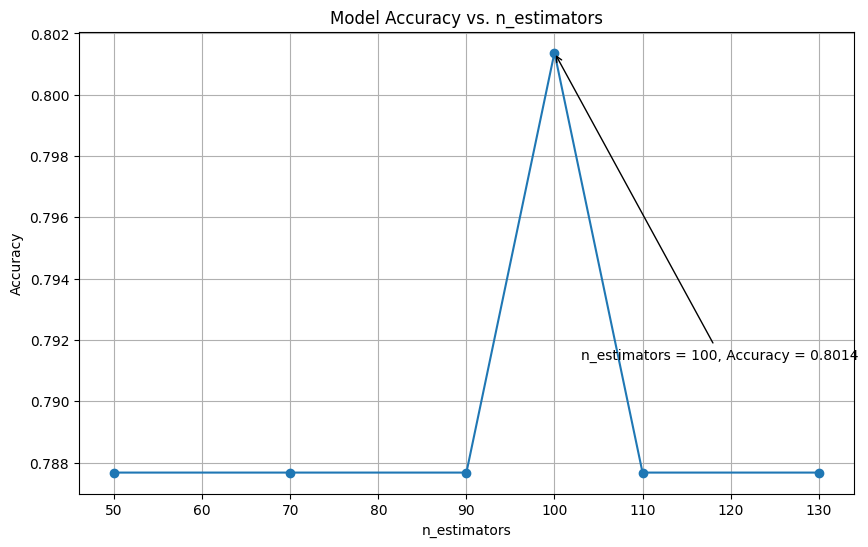

In [80]:
# Plot n_estimators_values vs accuracies
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, accuracies, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. n_estimators')
plt.grid(True)


max_accuracy_index = np.argmax(accuracies)


plt.annotate(f'n_estimators = {n_estimators_values[max_accuracy_index]}, Accuracy = {accuracies[max_accuracy_index]:.4f}',
             xy=(n_estimators_values[max_accuracy_index], accuracies[max_accuracy_index]),
             xytext=(n_estimators_values[max_accuracy_index] + 3, accuracies[max_accuracy_index] - 0.01),  # Adjust position of annotation
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Display the plot

plt.show()


In [81]:
fixed_params = {
    'n_estimators': 100,
    'max_depth': 8,
    'criterion': 'log_loss',
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'bootstrap': True,
    'random_state': 42
}


min_samples_split_values = [2, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]


accuracies = []


for min_samples_split in min_samples_split_values: # Iterate over n_estimators_values instead of max_depth_values
    params = fixed_params.copy()
    params['min_samples_split'] = min_samples_split
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    accuracies.append(accuracy)



for min_samples_split, acc in zip(min_samples_split_values, accuracies): # Use n_estimators_values in output as well
    print(f"min_samples_split: {min_samples_split}, Test Accuracy: {acc:.4f}")

min_samples_split: 2, Test Accuracy: 0.7671
min_samples_split: 5, Test Accuracy: 0.7808
min_samples_split: 6, Test Accuracy: 0.7945
min_samples_split: 7, Test Accuracy: 0.7877
min_samples_split: 8, Test Accuracy: 0.7808
min_samples_split: 9, Test Accuracy: 0.7740
min_samples_split: 10, Test Accuracy: 0.7877
min_samples_split: 15, Test Accuracy: 0.7877
min_samples_split: 20, Test Accuracy: 0.8014
min_samples_split: 25, Test Accuracy: 0.7740
min_samples_split: 30, Test Accuracy: 0.7740
min_samples_split: 40, Test Accuracy: 0.7808
min_samples_split: 50, Test Accuracy: 0.7671
min_samples_split: 60, Test Accuracy: 0.7671
min_samples_split: 70, Test Accuracy: 0.7534
min_samples_split: 80, Test Accuracy: 0.7534
min_samples_split: 90, Test Accuracy: 0.7671
min_samples_split: 100, Test Accuracy: 0.7671


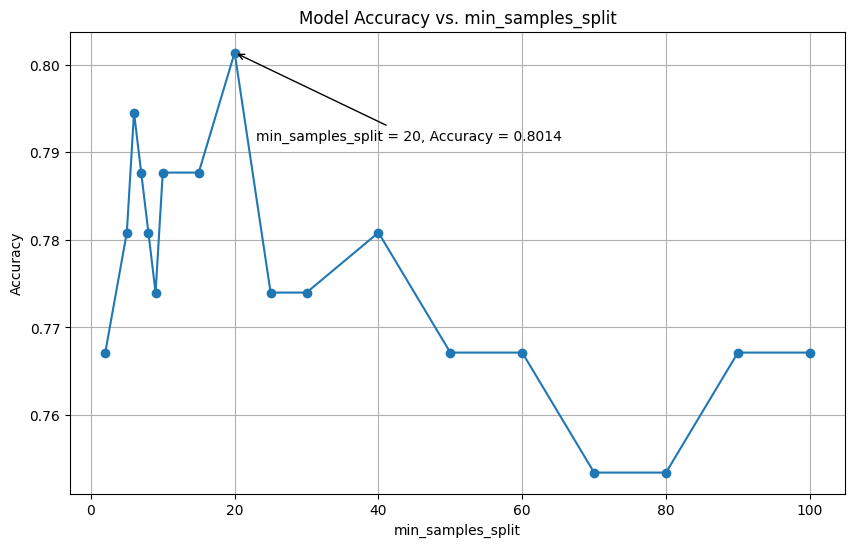

In [82]:
# Plot min_samples_split_values vs accuracies
plt.figure(figsize=(10, 6))
plt.plot(min_samples_split_values, accuracies, marker='o')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. min_samples_split')
plt.grid(True)

# Find the index of the maximum accuracy
max_accuracy_index = np.argmax(accuracies)

# Draw an arrow to the maximum accuracy point
plt.annotate(f'min_samples_split = {min_samples_split_values[max_accuracy_index]}, Accuracy = {accuracies[max_accuracy_index]:.4f}',
             xy=(min_samples_split_values[max_accuracy_index], accuracies[max_accuracy_index]),
             xytext=(min_samples_split_values[max_accuracy_index] + 3, accuracies[max_accuracy_index] - 0.01),  # Adjust position of annotation
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Display the plot

plt.show()


In [83]:
fixed_params = {
    'n_estimators': 100,
    'max_depth': 8,
    'criterion': 'log_loss',
    'min_samples_split': 20,
    'max_features': 'log2',
    'bootstrap': True,
    'random_state': 42
}


min_samples_leafـvalues = [2, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]


accuracies = []


for min_samples_leaf in min_samples_leafـvalues:
    params = fixed_params.copy()
    params['min_samples_leaf'] = min_samples_leaf
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    accuracies.append(accuracy)

# نمایش نتایج
for min_samples_leaf, acc in zip(min_samples_leafـvalues, accuracies):
    print(f"min_samples_leaf: {min_samples_leaf}, Test Accuracy: {acc:.4f}")

min_samples_leaf: 2, Test Accuracy: 0.8082
min_samples_leaf: 5, Test Accuracy: 0.7740
min_samples_leaf: 6, Test Accuracy: 0.7603
min_samples_leaf: 7, Test Accuracy: 0.7603
min_samples_leaf: 8, Test Accuracy: 0.7534
min_samples_leaf: 9, Test Accuracy: 0.7671
min_samples_leaf: 10, Test Accuracy: 0.7671
min_samples_leaf: 15, Test Accuracy: 0.7603
min_samples_leaf: 20, Test Accuracy: 0.7603
min_samples_leaf: 25, Test Accuracy: 0.7603
min_samples_leaf: 30, Test Accuracy: 0.7603
min_samples_leaf: 40, Test Accuracy: 0.7603
min_samples_leaf: 50, Test Accuracy: 0.7603
min_samples_leaf: 60, Test Accuracy: 0.7603
min_samples_leaf: 70, Test Accuracy: 0.7603
min_samples_leaf: 80, Test Accuracy: 0.7603
min_samples_leaf: 90, Test Accuracy: 0.7603
min_samples_leaf: 100, Test Accuracy: 0.7603


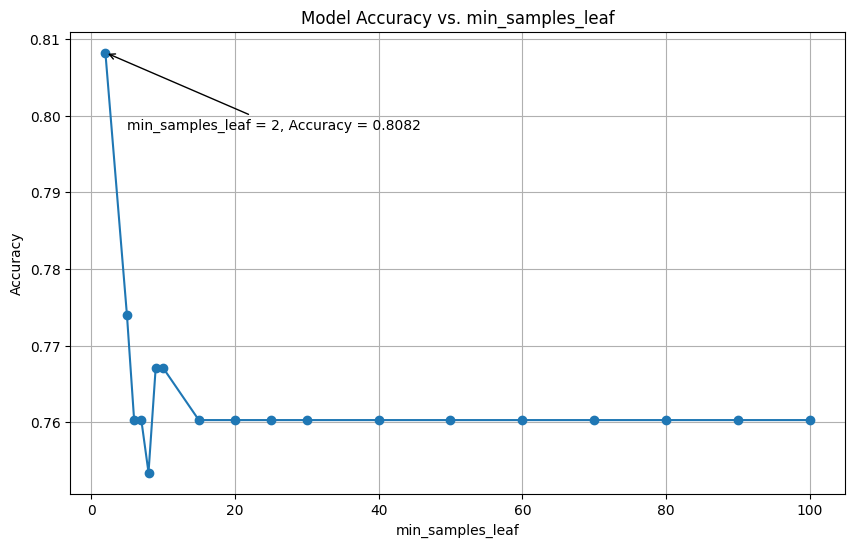

In [84]:
# Plot min_samples_leafـvalues vs accuracies
plt.figure(figsize=(10, 6))
plt.plot(min_samples_leafـvalues, accuracies, marker='o')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. min_samples_leaf')
plt.grid(True)


max_accuracy_index = np.argmax(accuracies)


plt.annotate(f'min_samples_leaf = {min_samples_leafـvalues[max_accuracy_index]}, Accuracy = {accuracies[max_accuracy_index]:.4f}',
             xy=(min_samples_leafـvalues[max_accuracy_index], accuracies[max_accuracy_index]),
             xytext=(min_samples_leafـvalues[max_accuracy_index] + 3, accuracies[max_accuracy_index] - 0.01),  # Adjust position of annotation
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Display the plot

plt.show()


In [163]:
fixed_params = {
    'n_estimators': 100,
    'max_depth': 8,
    'criterion': 'log_loss',
    'min_samples_split': 20,
    'min_samples_leaf' : 2,
    'max_features': 'log2',
    'bootstrap': True,
    'random_state': 42
}



params = fixed_params.copy()
model = RandomForestClassifier(**params)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8082


In [86]:
# Perform cross-validation with 5 folds
scores = cross_val_score(model, X_train, y_train, cv=5)

# Print the mean and standard deviation of the accuracy scores
print("Cross-Validation Accuracy Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())


Cross-Validation Accuracy Scores: [0.73504274 0.70940171 0.73275862 0.80172414 0.77586207]
Mean Accuracy: 0.7509578544061303
Standard Deviation: 0.03319292625122827


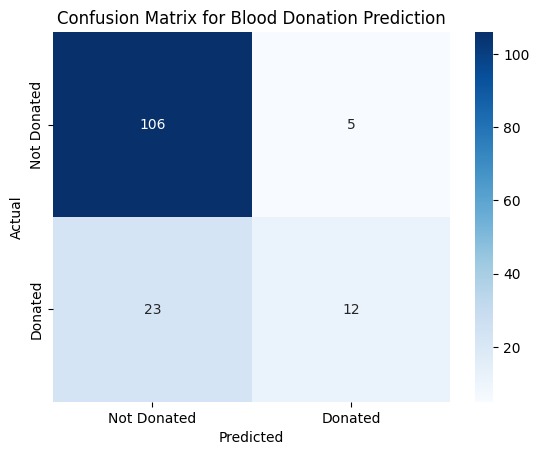

In [87]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create a heatmap visualization of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['Not Donated', 'Donated'], yticklabels=['Not Donated', 'Donated'])

# Set labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Blood Donation Prediction")

# Display the plot
plt.show()


#Beysian Optimization for Random Forest

In [177]:
X = df_mahala_no_outliers[['Recency (months)', 'Frequency (times)']]
y = df_mahala_no_outliers['whether he/she donated blood in March 2007']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def rf_cv(n_estimators, min_samples_split, max_features, min_samples_leaf, max_depth, criterion):

    if criterion <0.33:
        criterion = 'gini'
    elif criterion < 0.66:
        criterion = 'entropy'
    else:
        criterion = 'log_loss'

    model = RandomForestClassifier(
        n_estimators=int(n_estimators),
        min_samples_split=int(min_samples_split),
        max_features=max_features,
        min_samples_leaf = int(min_samples_leaf),
        max_depth = int(max_depth),
        criterion=criterion,
        random_state=42
    )
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return accuracy_score(y_test, predictions)


pbounds = {
    'n_estimators': (10, 200),
    'min_samples_split': (2, 10),
    'max_features': (0.1, 1.0),
    'min_samples_leaf': (1.0, 40.0),
    'max_depth': (1.0, 20.0),
    'criterion': (0, 1)

}

optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(
    init_points=2,
    n_iter=15,
)


print(optimizer.max)


|   iter    |  target   | criterion | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | 0.7603    | 0.3745    | 19.06     | 0.7588    | 24.35     | 3.248     | 39.64     |
| 2         | 0.7603    | 0.05808   | 17.46     | 0.641     | 28.61     | 2.165     | 194.3     |
| 3         | 0.7877    | 0.3682    | 8.807     | 0.8033    | 1.572     | 7.284     | 10.02     |
| 4         | 0.7945    | 0.3895    | 7.836     | 0.7786    | 1.454     | 6.894     | 10.24     |
| 5         | 0.7534    | 0.5496    | 5.173     | 0.7188    | 1.309     | 4.809     | 11.51     |
| 6         | 0.774     | 0.2308    | 7.165     | 0.7475    | 1.071     | 8.362     | 10.0      |
| 7         | 0.7877    | 0.9381    | 8.238     | 0.1       | 1.922     | 6.066     | 10.0      |
| 8         | 0.774     | 0.0       | 8.633     | 1.0       | 1.0       | 6.038     | 11.18     |
| 9         | 0.7671

In [178]:
best_params = optimizer.max['params']
if best_params['criterion'] < 0.33:
    best_params['criterion'] = 'gini'
elif best_params['criterion'] < 0.66:
    best_params['criterion'] = 'entropy'
else:
    best_params['criterion'] = 'log_loss'

best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])
best_params['max_depth'] = int(best_params['max_depth'])


final_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    criterion=best_params['criterion'],
    random_state=42
)

final_model.fit(X_train, y_train)
final_predictions = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_predictions)

print(f'Final model accuracy: {final_accuracy}')
print(f'Best parameters: {best_params}')

Final model accuracy: 0.7945205479452054
Best parameters: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 0.7785923473459193, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 10}


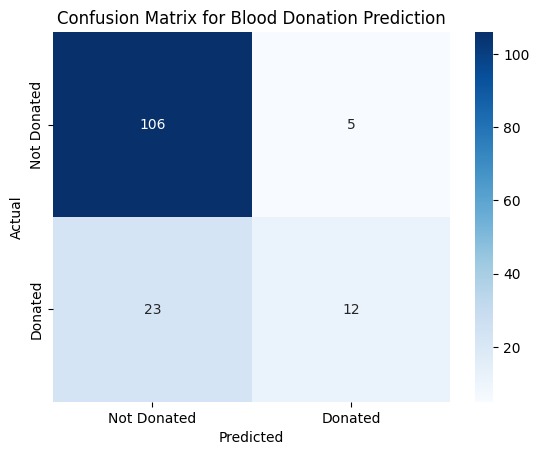

In [179]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create a heatmap visualization of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['Not Donated', 'Donated'], yticklabels=['Not Donated', 'Donated'])

# Set labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Blood Donation Prediction")

# Display the plot
plt.show()
